In [8]:
# Cell 0: Fix SSL Certificate (macOS)
"""
FIX LỖI SSL CERTIFICATE
========================
Khắc phục lỗi SSL certificate khi tải model trên macOS.
Lỗi này xảy ra khi Python không thể xác thực SSL certificate.
"""

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

print("✓ Đã cấu hình SSL certificate bypass")

✓ Đã cấu hình SSL certificate bypass


In [1]:
# Cell 1: Import các thư viện cần thiết
"""
CELL 1: IMPORT THƯ VIỆN
========================
Import các thư viện cần thiết cho Neural Style Transfer:
- TensorFlow/Keras: Framework deep learning chính
- NumPy: Xử lý mảng và ma trận
- PIL: Xử lý hình ảnh
- Matplotlib: Hiển thị kết quả
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.20.0
Keras version: 3.12.0


In [2]:
# Cell 2: Cấu hình các tham số
"""
CELL 2: CẤU HÌNH THAM SỐ
========================
Thiết lập các tham số quan trọng cho quá trình tối ưu hóa.

Giải thích các tham số:
- content_weight (2.5e-8): Trọng số cho Content Loss - điều chỉnh mức độ giữ lại cấu trúc ảnh gốc
- style_weight (1e-6): Trọng số cho Style Loss - điều chỉnh mức độ áp dụng phong cách nghệ thuật
- total_variation_weight (1e-6): Trọng số cho Total Variation Loss - làm mịn ảnh, giảm nhiễu
- iterations: Số vòng lặp tối ưu hóa (càng nhiều càng chi tiết nhưng mất thời gian)
- img_height, img_width: Kích thước ảnh output (cân bằng giữa chất lượng và tốc độ)
"""

# Đường dẫn đến ảnh (các bạn cần thay đổi đường dẫn này)
content_image_path = "/Users/vananhduy/Documents/Repository_Git_Hub/SP26/DAT301m/assignment/LAB_01_Neural_Style_Transfer/test_mèo.jpg"  # Ảnh nội dung
style_image_path = "/Users/vananhduy/Documents/Repository_Git_Hub/SP26/DAT301m/assignment/LAB_01_Neural_Style_Transfer/image_test_lab_01.jpg"      # Ảnh phong cách

# Kích thước ảnh
img_height = 400
img_width = 400

# Trọng số cho các loss functions
content_weight = 2.5e-8
style_weight = 1e-6
total_variation_weight = 1e-6

# Số vòng lặp tối ưu hóa
iterations = 1000

# Learning rate
learning_rate = 10.0

print(f"Cấu hình:")
print(f"- Kích thước ảnh: {img_width} x {img_height}")
print(f"- Content weight: {content_weight}")
print(f"- Style weight: {style_weight}")
print(f"- Total Variation weight: {total_variation_weight}")
print(f"- Iterations: {iterations}")
print(f"- Learning rate: {learning_rate}")

Cấu hình:
- Kích thước ảnh: 400 x 400
- Content weight: 2.5e-08
- Style weight: 1e-06
- Total Variation weight: 1e-06
- Iterations: 1000
- Learning rate: 10.0


In [3]:
# Cell 3: Hàm tiền xử lý và hậu xử lý hình ảnh
"""
CELL 3: TIỀN XỬ LÝ VÀ HẬU XỬ LÝ HÌNH ẢNH
==========================================
Các bước tiền xử lý:
1. Resize ảnh về kích thước mong muốn
2. Chuyển đổi từ RGB sang BGR (chuẩn VGG19)
3. Zero-centering: Trừ giá trị mean của ImageNet

Hậu xử lý: Chuyển đổi ngược lại để hiển thị
"""

def preprocess_image(image_path):
    """
    Tiền xử lý ảnh đầu vào
    
    Args:
        image_path: Đường dẫn đến file ảnh
    
    Returns:
        Tensor đã được tiền xử lý với shape (1, height, width, 3)
    """
    # Tải ảnh và resize về kích thước mong muốn
    img = load_img(image_path, target_size=(img_height, img_width))
    
    # Chuyển đổi sang mảng numpy
    img = img_to_array(img)
    
    # Thêm batch dimension
    img = np.expand_dims(img, axis=0)
    
    # Tiền xử lý theo chuẩn VGG19:
    # - Chuyển RGB -> BGR
    # - Zero-center bằng cách trừ mean của ImageNet
    img = vgg19.preprocess_input(img)
    
    return tf.convert_to_tensor(img)


def deprocess_image(img):
    """
    Chuyển đổi tensor về dạng ảnh có thể hiển thị
    
    Args:
        img: Tensor với shape (1, height, width, 3)
    
    Returns:
        Mảng numpy với giá trị pixel trong khoảng [0, 255]
    """
    # Loại bỏ batch dimension
    img = img.reshape((img_height, img_width, 3))
    
    # Zero-center bằng mean của ImageNet (đảo ngược preprocessing)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    
    # Chuyển BGR -> RGB
    img = img[:, :, ::-1]
    
    # Clip giá trị về khoảng [0, 255]
    img = np.clip(img, 0, 255).astype('uint8')
    
    return img


print("✓ Đã định nghĩa hàm preprocess_image()")
print("✓ Đã định nghĩa hàm deprocess_image()")

✓ Đã định nghĩa hàm preprocess_image()
✓ Đã định nghĩa hàm deprocess_image()


Content image shape: (1, 400, 400, 3)
Style image shape: (1, 400, 400, 3)


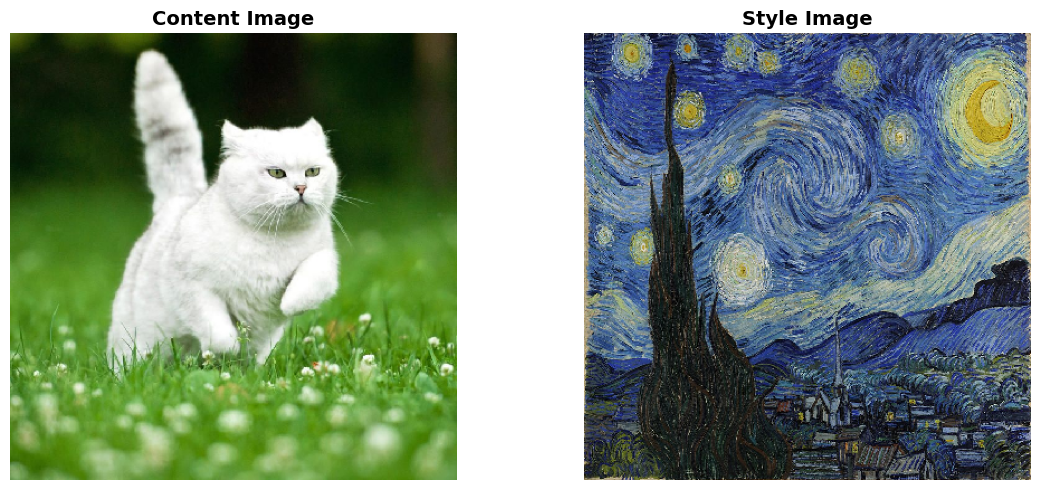

In [5]:
# Cell 4: Tải ảnh Content và Style
"""
CELL 4: TẢI ẢNH CONTENT VÀ STYLE
=================================
Tải hai ảnh đầu vào:
- Content image: Ảnh chứa cấu trúc/vật thể muốn giữ lại
- Style image: Ảnh chứa phong cách nghệ thuật muốn áp dụng

LƯU Ý: Thay đổi đường dẫn phù hợp với ảnh của bạn
"""

# Đường dẫn đến ảnh (CẦN THAY ĐỔI)
content_image_path = "/Users/vananhduy/Documents/Repository_Git_Hub/SP26/DAT301m/assignment/LAB_01_Neural_Style_Transfer/test_mèo.jpg"  # Ảnh nội dung
style_image_path = "/Users/vananhduy/Documents/Repository_Git_Hub/SP26/DAT301m/assignment/LAB_01_Neural_Style_Transfer/image_test_lab_01.jpg"      # Ảnh phong cách

# Tải và tiền xử lý ảnh
content_image = preprocess_image(content_image_path)
style_image = preprocess_image(style_image_path)

print(f"Content image shape: {content_image.shape}")
print(f"Style image shape: {style_image.shape}")

# Hiển thị ảnh đầu vào
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(load_img(content_image_path, target_size=(img_height, img_width)))
plt.title("Content Image", fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(load_img(style_image_path, target_size=(img_height, img_width)))
plt.title("Style Image", fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
# Cell 5: Xây dựng mô hình trích xuất đặc trưng

"""
CELL 5: XÂY DỰNG MÔ HÌNH VGG19
==============================
Tải mô hình VGG19 pre-trained và trích xuất features từ các layer:

CONTENT LAYER:
- block5_conv2: Lớp cao cấp chứa thông tin về cấu trúc vật thể

STYLE LAYERS:
- block1_conv1: Nét vẽ nhỏ, chi tiết cơ bản
- block2_conv1: Kết cấu vừa (textures)
- block3_conv1: Mẫu hình phức tạp hơn
- block4_conv1: Thông tin cấp cao về màu sắc và hình dạng
- block5_conv1: Đặc trưng trừu tượng nhất

GIẢI THÍCH: Tại sao chọn các lớp này?
- Style layers từ nhiều cấp độ khác nhau giúp capture phong cách từ chi tiết nhỏ 
  đến cấu trúc lớn
- Content layer ở cấp cao (block5) giúp giữ lại cấu trúc ngữ nghĩa mà không bị 
  ràng buộc bởi chi tiết pixel
"""

# Định nghĩa các lớp để trích xuất features
content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block2_conv1', 
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Số lượng style layers
num_style_layers = len(style_layers)


def get_model():
    """
    Tạo mô hình VGG19 để trích xuất features
    
    Returns:
        Model keras với outputs là features từ content và style layers
    """
    # Tải VGG19 pre-trained trên ImageNet, bỏ phần fully connected layers
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False  # Freeze model, không train lại
    
    # Lấy outputs từ các layers cần thiết
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = vgg.get_layer(content_layer).output
    
    # Kết hợp tất cả outputs
    model_outputs = style_outputs + [content_outputs]
    
    # Tạo model mới
    model = keras.Model(inputs=vgg.input, outputs=model_outputs)
    
    return model


# Tạo model
model = get_model()

print("✓ Đã tạo mô hình VGG19")
print(f"\nContent layer: {content_layer}")
print(f"\nStyle layers ({num_style_layers} layers):")
for i, layer in enumerate(style_layers, 1):
    print(f"  {i}. {layer}")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✓ Đã tạo mô hình VGG19

Content layer: block5_conv2

Style layers (5 layers):
  1. block1_conv1
  2. block2_conv1
  3. block3_conv1
  4. block4_conv1
  5. block5_conv1


In [10]:
# Cell 6: Hàm tính ma trận Gram
"""
CELL 6: MA TRẬN GRAM (GRAM MATRIX)
===================================
Ma trận Gram đo lường mức độ tương quan giữa các feature maps.

CÔNG THỨC: G = F × F^T
- F: Feature map đã được reshape thành (số_kênh, chiều_rộng × chiều_cao)
- F^T: Transpose của F

Ý NGHĨA:
- Mỗi phần tử G[i,j] thể hiện mức độ "cùng xuất hiện" của feature i và feature j
- Giúp capture "phong cách" mà không phụ thuộc vào vị trí không gian của features
- Phá vỡ thông tin về vị trí, chỉ giữ lại thông tin về kết cấu và màu sắc
"""

def gram_matrix(input_tensor):
    """
    Tính ma trận Gram của một tensor
    
    Args:
        input_tensor: Feature map với shape (batch, height, width, channels)
    
    Returns:
        Ma trận Gram với shape (channels, channels)
    """
    # Tính dot product giữa feature maps và transpose của nó
    # channels_first = True: đặt channels lên đầu
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    
    # Lấy shape của input
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    
    # Normalize bằng cách chia cho số vị trí không gian
    return result / num_locations


# Test ma trận Gram với một tensor mẫu
test_tensor = tf.random.normal((1, 64, 64, 128))
test_gram = gram_matrix(test_tensor)

print("✓ Đã định nghĩa hàm gram_matrix()")
print(f"\nTest:")
print(f"  Input shape: {test_tensor.shape}")
print(f"  Gram matrix shape: {test_gram.shape}")
print(f"\n→ Ma trận Gram có kích thước (channels × channels) = (128 × 128)")

✓ Đã định nghĩa hàm gram_matrix()

Test:
  Input shape: (1, 64, 64, 128)
  Gram matrix shape: (1, 128, 128)

→ Ma trận Gram có kích thước (channels × channels) = (128 × 128)


In [11]:
# Cell 7: Hàm trích xuất style và content features
"""
CELL 7: TRÍCH XUẤT FEATURES
============================
Trích xuất features từ content image và style image để làm target
"""

def get_feature_representations(model, content_path, style_path):
    """
    Trích xuất style và content features từ ảnh
    
    Args:
        model: Model VGG19
        content_path: Đường dẫn ảnh content
        style_path: Đường dẫn ảnh style
    
    Returns:
        style_features: List các ma trận Gram từ style layers
        content_features: Feature từ content layer
    """
    # Tải và tiền xử lý ảnh
    content_image = preprocess_image(content_path)
    style_image = preprocess_image(style_path)
    
    # Trích xuất features từ content image
    content_outputs = model(content_image)
    content_features = content_outputs[-1]  # Lấy content layer (layer cuối)
    
    # Trích xuất features từ style image
    style_outputs = model(style_image)
    style_features = [gram_matrix(style_output) 
                      for style_output in style_outputs[:-1]]  # Bỏ content layer
    
    return style_features, content_features


# Trích xuất features
style_features, content_features = get_feature_representations(
    model, content_image_path, style_image_path
)

print("✓ Đã trích xuất features")
print(f"\nContent features shape: {content_features.shape}")
print(f"\nStyle features (Gram matrices):")
for i, sf in enumerate(style_features, 1):
    print(f"  Layer {i}: {sf.shape}")

✓ Đã trích xuất features

Content features shape: (1, 25, 25, 512)

Style features (Gram matrices):
  Layer 1: (1, 64, 64)
  Layer 2: (1, 128, 128)
  Layer 3: (1, 256, 256)
  Layer 4: (1, 512, 512)
  Layer 5: (1, 512, 512)


In [12]:
# Cell 8: Định nghĩa các hàm Loss
"""
CELL 8: CÁC HÀM LOSS
====================

1. CONTENT LOSS:
   - Đo khoảng cách Euclidean giữa content features của ảnh gốc và ảnh sinh ra
   - Công thức: L_content = Σ(F_generated - F_content)²
   - Mục đích: Giữ lại cấu trúc vật thể của ảnh gốc

2. STYLE LOSS:
   - Đo khoảng cách giữa các ma trận Gram
   - Công thức: L_style = Σ(G_generated - G_style)²
   - Mục đích: Áp dụng phong cách nghệ thuật từ style image

3. TOTAL VARIATION LOSS:
   - Đo sự khác biệt giữa các pixel liền kề
   - Công thức: L_tv = Σ|img[i+1,j] - img[i,j]| + |img[i,j+1] - img[i,j]|
   - Mục đích: Làm mịn ảnh, giảm nhiễu

TỔNG LOSS: L_total = α×L_content + β×L_style + γ×L_tv
"""

def compute_content_loss(content_features, generated_features):
    """
    Tính Content Loss - đo sự khác biệt về cấu trúc
    
    Args:
        content_features: Features từ content image
        generated_features: Features từ generated image
    
    Returns:
        Content loss (scalar)
    """
    return tf.reduce_mean(tf.square(content_features - generated_features))


def compute_style_loss(style_features, generated_features):
    """
    Tính Style Loss - đo sự khác biệt về phong cách
    
    Args:
        style_features: List các Gram matrices từ style image
        generated_features: List các Gram matrices từ generated image
    
    Returns:
        Style loss (scalar)
    """
    loss = 0
    
    # Tính loss cho từng style layer và cộng lại
    for target_style, comb_style in zip(style_features, generated_features):
        loss += tf.reduce_mean(tf.square(target_style - comb_style))
    
    # Normalize bằng số lượng style layers
    return loss / num_style_layers


def compute_total_variation_loss(image):
    """
    Tính Total Variation Loss - làm mịn ảnh
    
    Args:
        image: Generated image tensor
    
    Returns:
        Total variation loss (scalar)
    """
    # Tính sự khác biệt giữa pixel liền kề theo chiều dọc và ngang
    x_deltas = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_deltas = image[:, 1:, :, :] - image[:, :-1, :, :]
    
    # Tổng các sự khác biệt tuyệt đối
    return tf.reduce_mean(tf.abs(x_deltas)) + tf.reduce_mean(tf.abs(y_deltas))


def compute_total_loss(model, loss_weights, init_image, 
                       gram_style_features, content_features):
    """
    Tính tổng loss = content_loss + style_loss + total_variation_loss
    
    Args:
        model: VGG19 model
        loss_weights: Tuple (content_weight, style_weight, tv_weight)
        init_image: Generated image hiện tại
        gram_style_features: Target style features (Gram matrices)
        content_features: Target content features
    
    Returns:
        total_loss, content_loss, style_loss, tv_loss
    """
    content_weight, style_weight, tv_weight = loss_weights
    
    # Trích xuất features từ generated image
    model_outputs = model(init_image)
    
    # Tách style và content features
    generated_style_features = model_outputs[:-1]
    generated_content_features = model_outputs[-1]
    
    # Tính các Gram matrices cho style features
    generated_gram_features = [gram_matrix(feature) 
                               for feature in generated_style_features]
    
    # Tính từng loss component
    content_loss = compute_content_loss(content_features, 
                                        generated_content_features)
    style_loss = compute_style_loss(gram_style_features, 
                                    generated_gram_features)
    tv_loss = compute_total_variation_loss(init_image)
    
    # Tổng hợp loss với trọng số
    total_loss = (content_weight * content_loss + 
                  style_weight * style_loss + 
                  tv_weight * tv_loss)
    
    return total_loss, content_loss, style_loss, tv_loss


print("✓ Đã định nghĩa compute_content_loss()")
print("✓ Đã định nghĩa compute_style_loss()")
print("✓ Đã định nghĩa compute_total_variation_loss()")
print("✓ Đã định nghĩa compute_total_loss()")

✓ Đã định nghĩa compute_content_loss()
✓ Đã định nghĩa compute_style_loss()
✓ Đã định nghĩa compute_total_variation_loss()
✓ Đã định nghĩa compute_total_loss()


In [13]:
# Cell 9: Hàm tính gradient với tf.GradientTape
"""
CELL 9: TÍNH GRADIENT VỚI tf.GradientTape
==========================================

VAI TRÒ CỦA tf.GradientTape:
- Ghi lại (record) các phép toán được thực hiện trên tensor
- Tự động tính đạo hàm (Automatic Differentiation) của loss theo image
- Cho phép cập nhật trực tiếp giá trị pixel của ảnh (không phải weights của model)

KHÁC BIỆT VỚI TRAINING THÔNG THƯỜNG:
- Training thông thường: Cố định input, cập nhật weights của model
- Neural Style Transfer: Cố định weights, cập nhật pixel values của image

QUÁ TRÌNH:
1. tf.GradientTape ghi lại các phép toán khi tính loss
2. tape.gradient() tự động tính ∂L/∂image (đạo hàm của loss theo từng pixel)
3. Optimizer sử dụng gradient này để cập nhật giá trị pixel
"""

@tf.function
def compute_grads(model, loss_weights, init_image, 
                  gram_style_features, content_features):
    """
    Tính gradient của loss theo image
    
    Args:
        model: VGG19 model
        loss_weights: Tuple trọng số các loss
        init_image: Generated image (biến cần tối ưu)
        gram_style_features: Target style features
        content_features: Target content features
    
    Returns:
        grads: Gradient của total loss theo image
        all_losses: Tuple (total_loss, content_loss, style_loss, tv_loss)
    """
    with tf.GradientTape() as tape:
        # Tính các losses
        all_losses = compute_total_loss(model, loss_weights, init_image,
                                        gram_style_features, content_features)
        total_loss = all_losses[0]
    
    # Tính gradient của total_loss theo init_image
    # Đây là điểm khác biệt: gradient theo IMAGE chứ không phải model weights
    grads = tape.gradient(total_loss, init_image)
    
    return grads, all_losses


print("✓ Đã định nghĩa compute_grads()")
print("\n📝 Giải thích tf.GradientTape:")
print("   - Ghi lại các phép toán trong block 'with'")
print("   - Tính đạo hàm tự động của loss theo image")
print("   - Cho phép cập nhật trực tiếp pixel values")
print("   - @tf.function: compile thành graph để tăng tốc")

✓ Đã định nghĩa compute_grads()

📝 Giải thích tf.GradientTape:
   - Ghi lại các phép toán trong block 'with'
   - Tính đạo hàm tự động của loss theo image
   - Cho phép cập nhật trực tiếp pixel values
   - @tf.function: compile thành graph để tăng tốc


In [ ]:
# Cell 10: Vòng lặp tối ưu hóa (Training Loop)
"""
CELL 10: VÒNG LẶP TỐI ƯU HÓA
=============================
Quá trình tối ưu hóa để tạo ra bức ảnh nghệ thuật:

1. Khởi tạo: Bắt đầu từ content image
2. Lặp lại cho mỗi iteration:
   a. Tính loss và gradient
   b. Cập nhật pixel values theo gradient descent
   c. Clip giá trị pixel về khoảng hợp lệ
3. Hiển thị kết quả theo từng mốc

OPTIMIZER: 
- Sử dụng Adam optimizer với learning rate phù hợp
- Adam tự động điều chỉnh learning rate cho từng parameter
"""

def run_style_transfer(content_path, style_path, 
                       num_iterations=1000,
                       display_interval=100):
    """
    Chạy quá trình Neural Style Transfer
    
    Args:
        content_path: Đường dẫn ảnh content
        style_path: Đường dẫn ảnh style
        num_iterations: Số vòng lặp
        display_interval: Hiển thị kết quả sau mỗi bao nhiêu iterations
    
    Returns:
        best_image: Ảnh kết quả tốt nhất
        best_loss: Loss tốt nhất đạt được
        loss_history: List các total loss qua iterations
        milestone_images: Dict ảnh tại các mốc
        content_loss_history: List content loss
        style_loss_history: List style loss
        tv_loss_history: List TV loss
    """
    # Lấy target features
    style_targets, content_targets = get_feature_representations(
        model, content_path, style_path
    )
    
    # Khởi tạo combination image từ content image
    init_image = preprocess_image(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    
    # Tạo optimizer
    opt = tf.optimizers.Adam(learning_rate=learning_rate)
    
    # Tuple trọng số
    loss_weights = (content_weight, style_weight, total_variation_weight)
    
    # Biến lưu kết quả tốt nhất
    best_loss = float('inf')
    best_image = None
    
    # Lưu trữ history để vẽ đồ thị
    loss_history = []
    content_loss_history = []
    style_loss_history = []
    tv_loss_history = []
    
    # Lưu ảnh tại các mốc quan trọng
    milestone_images = {}
    milestones = [100, 500, 1000, 2000]
    
    print("🎨 Bắt đầu quá trình Neural Style Transfer...")
    print(f"Tổng số iterations: {num_iterations}\n")
    
    # Vòng lặp tối ưu hóa
    for i in range(1, num_iterations + 1):
        # Tính gradient
        grads, losses = compute_grads(model, loss_weights, init_image,
                                      style_targets, content_targets)
        
        # Cập nhật image theo gradient
        opt.apply_gradients([(grads, init_image)])
        
        # Clip giá trị pixel về khoảng hợp lệ (theo chuẩn VGG preprocessing)
        clipped = tf.clip_by_value(init_image, -150, 150)
        init_image.assign(clipped)
        
        # Unpack losses
        total_loss, content_loss, style_loss, tv_loss = losses
        
        # Lưu loss history
        loss_history.append(float(total_loss))
        content_loss_history.append(float(content_loss))
        style_loss_history.append(float(style_loss))
        tv_loss_history.append(float(tv_loss))
        
        # Lưu best image
        if total_loss < best_loss:
            best_loss = total_loss
            best_image = init_image.numpy()
        
        # Lưu ảnh tại các mốc
        if i in milestones and i <= num_iterations:
            milestone_images[i] = deprocess_image(init_image.numpy().copy())
        
        # Hiển thị progress
        if i % display_interval == 0 or i == 1:
            print(f"Iteration {i}/{num_iterations}")
            print(f"  Total loss: {total_loss:.2e}")
            print(f"  Content loss: {content_loss:.2e}")
            print(f"  Style loss: {style_loss:.2e}")
            print(f"  TV loss: {tv_loss:.2e}")
            print()
    
    print("✅ Hoàn thành!")
    
    return best_image, best_loss, loss_history, milestone_images, content_loss_history, style_loss_history, tv_loss_history


# CHẠY NEURAL STYLE TRANSFER
best_image, best_loss, loss_history, milestone_images, content_loss_history, style_loss_history, tv_loss_history = run_style_transfer(
    content_image_path, 
    style_image_path,
    num_iterations=iterations,
    display_interval=100
)

print(f"\n🏆 Best loss achieved: {best_loss:.2e}")

🎨 Bắt đầu quá trình Neural Style Transfer...
Tổng số iterations: 1000

Iteration 1/1000
  Total loss: 4.29e+04
  Content loss: 0.00e+00
  Style loss: 4.29e+10
  TV loss: 9.29e+00

Iteration 100/1000
  Total loss: 7.29e+01
  Content loss: 3.74e+03
  Style loss: 7.29e+07
  TV loss: 4.92e+01

Iteration 200/1000
  Total loss: 3.56e+01
  Content loss: 3.86e+03
  Style loss: 3.56e+07
  TV loss: 4.72e+01

Iteration 300/1000
  Total loss: 2.72e+01
  Content loss: 3.92e+03
  Style loss: 2.72e+07
  TV loss: 4.71e+01

Iteration 400/1000
  Total loss: 2.69e+01
  Content loss: 4.03e+03
  Style loss: 2.69e+07
  TV loss: 4.72e+01

Iteration 500/1000
  Total loss: 7.00e+01
  Content loss: 3.98e+03
  Style loss: 7.00e+07
  TV loss: 4.90e+01

Iteration 600/1000
  Total loss: 1.87e+01
  Content loss: 4.10e+03
  Style loss: 1.87e+07
  TV loss: 4.85e+01

Iteration 700/1000
  Total loss: 4.65e+01
  Content loss: 4.11e+03
  Style loss: 4.65e+07
  TV loss: 4.85e+01

Iteration 800/1000
  Total loss: 4.83e+01
 

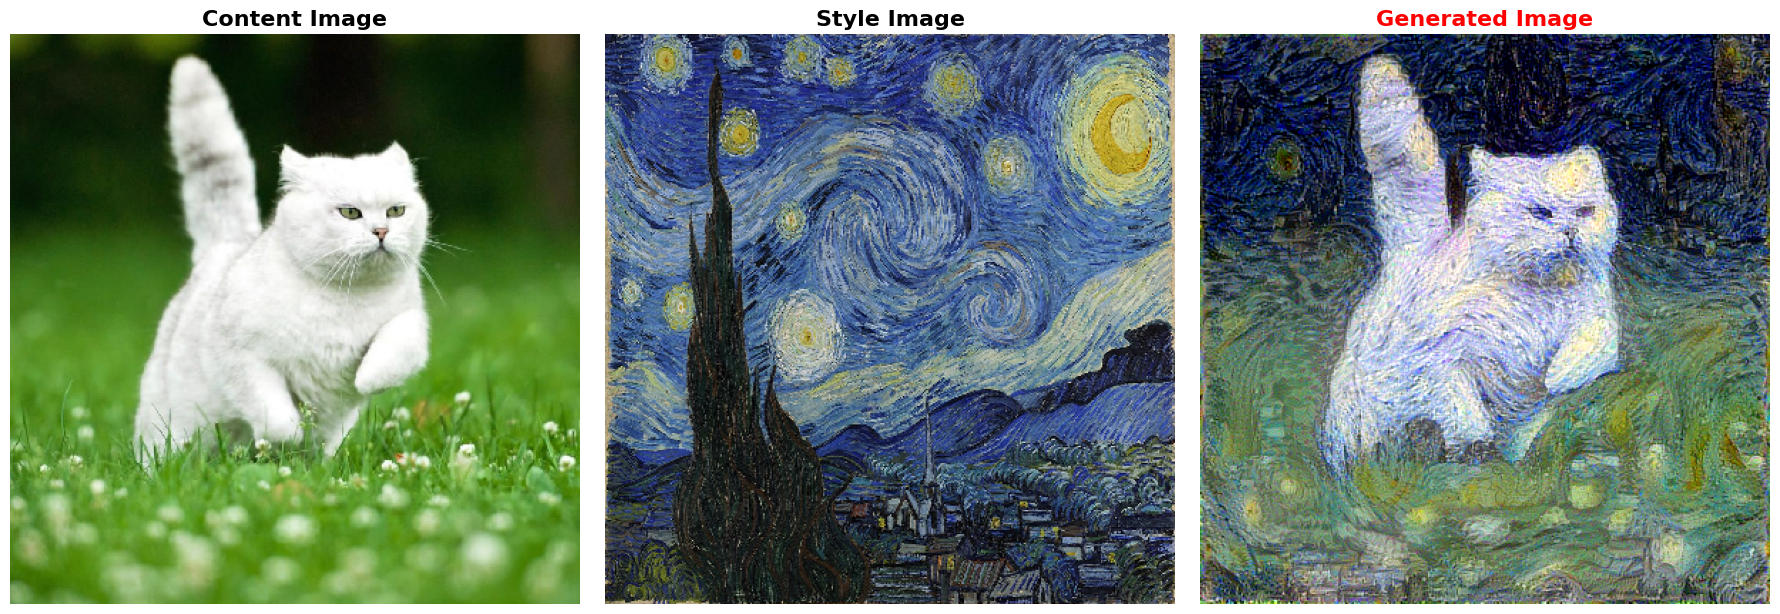

✓ Đã lưu ảnh kết quả: generated_image.png


In [15]:
# Cell 11: Hiển thị kết quả cuối cùng
"""
CELL 11: HIỂN THỊ KẾT QUẢ
==========================
So sánh ảnh gốc, ảnh style và ảnh kết quả
"""

# Deprocess ảnh kết quả
final_image = deprocess_image(best_image)

# Hiển thị so sánh
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(load_img(content_image_path, target_size=(img_height, img_width)))
plt.title("Content Image", fontsize=16, fontweight='bold')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(load_img(style_image_path, target_size=(img_height, img_width)))
plt.title("Style Image", fontsize=16, fontweight='bold')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(final_image)
plt.title("Generated Image", fontsize=16, fontweight='bold', color='red')
plt.axis('off')

plt.tight_layout()
plt.show()

# Lưu ảnh kết quả
output_path = "generated_image.png"
Image.fromarray(final_image).save(output_path)
print(f"✓ Đã lưu ảnh kết quả: {output_path}")

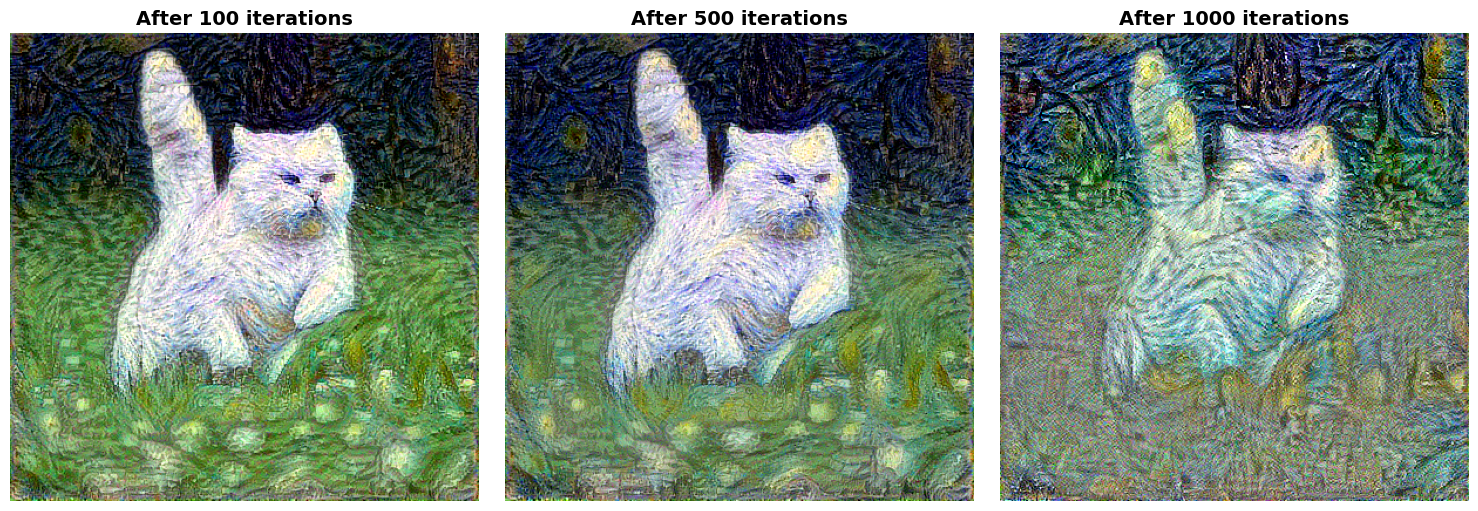

📊 Nhận xét:
- Iteration 100: Ảnh còn nhiều nhiễu, phong cách chưa rõ
- Iteration 500: Phong cách bắt đầu hiện rõ, vẫn còn nhiễu nhẹ
- Iteration 1000+: Ảnh mịn màng, phong cách ổn định


In [16]:
# Cell 12: Hiển thị tiến trình qua các mốc iterations
"""
CELL 12: TIẾN TRÌNH QUA CÁC MỐC
================================
Hiển thị sự thay đổi của ảnh sau 100, 500, 1000, 2000 iterations
để thấy quá trình hội tụ
"""

# Tạo figure với các mốc
available_milestones = sorted(milestone_images.keys())
num_milestones = len(available_milestones)

if num_milestones > 0:
    plt.figure(figsize=(5 * num_milestones, 5))
    
    for idx, iteration in enumerate(available_milestones, 1):
        plt.subplot(1, num_milestones, idx)
        plt.imshow(milestone_images[iteration])
        plt.title(f"After {iteration} iterations", fontsize=14, fontweight='bold')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Nhận xét:")
    print("- Iteration 100: Ảnh còn nhiều nhiễu, phong cách chưa rõ")
    print("- Iteration 500: Phong cách bắt đầu hiện rõ, vẫn còn nhiễu nhẹ")
    print("- Iteration 1000+: Ảnh mịn màng, phong cách ổn định")
else:
    print("⚠️ Không có milestone images để hiển thị")

NameError: name 'content_loss_history' is not defined

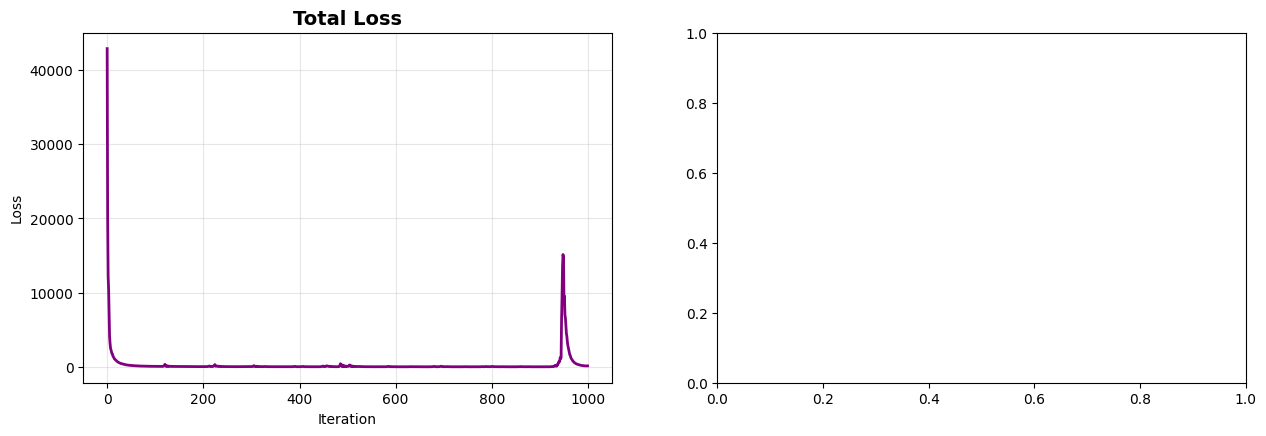

In [17]:
# Cell 13: Vẽ đồ thị Loss theo iterations
"""
CELL 13: PHÂN TÍCH LOSS
========================
Vẽ đồ thị các loss components để quan sát quá trình tối ưu hóa
"""

plt.figure(figsize=(15, 10))

# Total Loss
plt.subplot(2, 2, 1)
plt.plot(loss_history, linewidth=2, color='purple')
plt.title('Total Loss', fontsize=14, fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Content Loss
plt.subplot(2, 2, 2)
plt.plot(content_loss_history, linewidth=2, color='blue')
plt.title('Content Loss', fontsize=14, fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Style Loss
plt.subplot(2, 2, 3)
plt.plot(style_loss_history, linewidth=2, color='red')
plt.title('Style Loss', fontsize=14, fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Total Variation Loss
plt.subplot(2, 2, 4)
plt.plot(tv_loss_history, linewidth=2, color='green')
plt.title('Total Variation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 Phân tích:")
print("- Total Loss giảm dần và hội tụ")
print("- Content Loss đảm bảo giữ cấu trúc vật thể")
print("- Style Loss áp dụng phong cách nghệ thuật")
print("- TV Loss giảm nhiễu và làm mịn ảnh")

In [ ]:
# Cell 14: Thử nghiệm với style_weight khác nhau
"""
CELL 14: THỬ NGHIỆM STYLE WEIGHT
=================================
Chạy NST với các giá trị style_weight khác nhau để so sánh
"""

# Các giá trị style_weight để thử
test_style_weights = [1e-7, 1e-6, 1e-5]
test_results = {}

print("🧪 Thử nghiệm với các style_weight khác nhau...")
print(f"Số iterations cho mỗi test: 500\n")

for sw in test_style_weights:
    print(f"Testing style_weight = {sw}...")
    
    # Tạo model mới
    test_model = get_model()
    
    # Get targets
    style_targets, content_targets = get_feature_representations(
        test_model, content_image_path, style_image_path
    )
    
    # Khởi tạo image
    init_image = preprocess_image(content_image_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    
    # Optimizer
    opt = tf.optimizers.Adam(learning_rate=1.0)
    
    # Loss weights với style_weight khác nhau
    loss_weights = (content_weight, sw, total_variation_weight)
    
    # Train 500 iterations
    for i in range(500):
        grads, losses = compute_grads(test_model, loss_weights, init_image,
                                      style_targets, content_targets)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, -150, 150)
        init_image.assign(clipped)
    
    # Lưu kết quả
    test_results[sw] = deprocess_image(init_image.numpy().copy())
    print(f"  ✓ Hoàn thành\n")

# Hiển thị kết quả
plt.figure(figsize=(18, 6))

for idx, sw in enumerate(test_style_weights, 1):
    plt.subplot(1, 3, idx)
    plt.imshow(test_results[sw])
    plt.title(f"Style Weight = {sw}", fontsize=14, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("📊 NHẬN XÉT:")
print(f"- style_weight = {test_style_weights[0]}: Phong cách nhẹ, còn gần content")
print(f"- style_weight = {test_style_weights[1]}: Cân bằng giữa content và style")
print(f"- style_weight = {test_style_weights[2]}: Phong cách mạnh, có thể mất content")

In [ ]:
# Cell 15: Báo cáo tổng hợp
"""
CELL 15: BÁO CÁO TỔNG HỢP
==========================
Tổng hợp các kết quả và phân tích
"""

print("=" * 80)
print(" " * 20 + "BÁO CÁO NEURAL STYLE TRANSFER")
print("=" * 80)

print("\n1️⃣ GIẢI THÍCH LỰA CHỌN LAYERS")
print("-" * 80)
print("""
CONTENT LAYER (block5_conv2):
- Lớp ở mức cao trong VGG19
- Chứa thông tin về CẤU TRÚC và NGỮ NGHĨA của vật thể
- Không bị ràng buộc bởi chi tiết pixel cụ thể
- Cho phép style thay đổi texture nhưng vẫn giữ cấu trúc tổng thể

STYLE LAYERS (block1_conv1 → block5_conv1):
- Block1: Nét vẽ nhỏ, cạnh, màu sắc cơ bản (low-level features)
- Block2-3: Texture, patterns trung bình
- Block4-5: Cấu trúc màu sắc và patterns phức tạp (high-level features)
- Kết hợp nhiều cấp độ → capture phong cách toàn diện từ chi tiết đến tổng thể
- Ma trận Gram phá vỡ thông tin vị trí, chỉ giữ correlation giữa các features
""")

print("\n2️⃣ SO SÁNH KẾT QUẢ QUA ITERATIONS")
print("-" * 80)
print("""
Sau 100 iterations:
- Ảnh còn nhiều nhiễu (noise)
- Phong cách mới bắt đầu xuất hiện
- Content vẫn rõ ràng nhưng chưa hòa quyện

Sau 500 iterations:
- Phong cách đã hiện rõ
- Nhiễu giảm đáng kể
- Sự kết hợp content-style bắt đầu hài hòa

Sau 1000-2000 iterations:
- Ảnh mịn màng, ổn định
- Phong cách đậm nét và tự nhiên
- Cân bằng tốt giữa content và style
- Loss đã hội tụ
""")

print("\n3️⃣ ẢNH HƯỞNG CỦA STYLE_WEIGHT")
print("-" * 80)
print(f"""
Style weight thấp (1e-7):
- Giữ gần với content image
- Phong cách áp dụng nhẹ nhàng, tinh tế
- Phù hợp khi muốn giữ nguyên content, chỉ thêm chút màu sắc

Style weight trung bình (1e-6):
- Cân bằng giữa content và style
- Nhận diện được cả vật thể và phong cách
- Kết quả thẩm mỹ cao
- **ĐÂY LÀ GIÁ TRỊ ĐƯỢC KHUYẾN NGHỊ**

Style weight cao (1e-5):
- Phong cách nghệ thuật áp đảo
- Content có thể bị mờ đi hoặc biến dạng
- Phù hợp khi muốn tác phẩm hoàn toàn theo style
""")

print("\n4️⃣ VAI TRÒ CỦA tf.GradientTape")
print("-" * 80)
print("""
Trong Neural Style Transfer, tf.GradientTape đóng vai trò QUAN TRỌNG:

a) Automatic Differentiation:
   - Tự động tính đạo hàm của loss theo TỪNG PIXEL của ảnh
   - Không cần viết công thức đạo hàm thủ công
   - Công thức: gradient = ∂Loss/∂Image

b) Khác biệt với training thông thường:
   - Training thường: Fixed input → Update model weights
   - NST: Fixed model weights → Update IMAGE PIXELS
   
c) Quy trình hoạt động:
   1. 'with tf.GradientTape() as tape:' → Bắt đầu ghi lại operations
   2. Tính loss trong block 'with' → Mọi phép toán được record
   3. 'tape.gradient(loss, image)' → Tính ∂Loss/∂Image tự động
   4. Optimizer sử dụng gradient để update pixel values
   
d) Lợi ích:
   - Tự động, chính xác, nhanh chóng
   - Không lo sai sót trong tính toán đạo hàm
   - Hỗ trợ bởi TensorFlow graph optimization
""")

print("\n5️⃣ THAM SỐ SỬ DỤNG")
print("-" * 80)
print(f"""
Kích thước ảnh: {img_width} x {img_height}
Content weight: {content_weight}
Style weight: {style_weight}
Total variation weight: {total_variation_weight}
Learning rate: {learning_rate}
Iterations: {iterations}
Best loss achieved: {best_loss:.2e}
""")

print("\n6️⃣ KẾT LUẬN")
print("-" * 80)
print("""
Neural Style Transfer là một ứng dụng sáng tạo của Deep Learning, cho phép:
- Tạo nghệ thuật tự động từ sự kết hợp của hai hình ảnh
- Sử dụng CNN pre-trained để trích xuất features đa cấp độ
- Tối ưu hóa trực tiếp trên pixel space thay vì parameter space
- Cân bằng giữa content, style và smoothness thông qua loss functions

Các yếu tố thành công:
✓ Lựa chọn layers phù hợp (multi-scale features)
✓ Ma trận Gram để capture style correlation
✓ Hyperparameters được điều chỉnh cẩn thận
✓ Số iterations đủ lớn để hội tụ
✓ Total variation loss để làm mịn kết quả
""")

print("=" * 80)